In [1]:
import networkx as nx
import numpy as np
from os import listdir
import re

## wrangle data

In [52]:
# big function to convert .csv into a networkx Graph object
# along with all the bells and whistles such as node/edge colors into attributes
# note that the functions in subsequent cells may break if attributes are removed
def wrangle(path, normalise_flux=False, width_min=1, width_max=5, alpha_min=.4, alpha_max=.6):
    indices = []
    with open(path) as f:
        for line in f.readlines():
            indices.append([])
            for index in line.split(','):
                indices[-1].append(index.strip())
    
    # first set of targets should equal second set of sources
    assert indices[1] == indices[2]
    # interaction strengths are equal too
    assert indices[4] == indices[5]
    
    # create nx graph
    G = nx.DiGraph()
    G.graph['name'] = path[:-4] # remove '.csv'
    
    # local function to add edge to graph, sums flux if already in graph
    def add_flux(ij, flux):
        if G.has_edge(*ij):
            G.edges[ij]['weight'] += flux
        else:
            G.add_edge(*ij, weight=flux)
    
    # i is metabolite, j is species    
    for i,j,w in zip(indices[0], indices[1], indices[4]):
        ij = ('m'+i, j)
        add_flux(ij, float(w))
    
    # i is species, j is metabolite
    for i,j,w in zip(indices[2], indices[3], indices[5]):
        ij = (i, 'm'+j)
        add_flux(ij, float(w))

    nx.set_node_attributes(G, {i: 0 if i in indices[1] else 1 for i in G.nodes}, 'y')
    nx.set_node_attributes(G, {i: int(i[1:]) if 'm' in i else int(i) for i in G.nodes}, 'x')
    
    # set node and edge colours (from matplotlib 'tab10')
    col_species = [.97,.50,.27]
    col_metabol = [.12,.47,.71]
    nx.set_node_attributes(G, {i:col_species if G.nodes[i]['y']==1 else col_metabol for i in G.nodes}, 'color')
    
    # set edge weight attributes according to flux on that interaction
    flux_logmax = np.log(max(nx.get_edge_attributes(G, 'weight').values()))
    flux_logmin = np.log(min(nx.get_edge_attributes(G, 'weight').values()))
    cols_edge = {}
    widths_edge = {}
    for ij in G.edges:
        flux_norm = (np.log(G.edges[ij]['weight'])-flux_logmin) / (flux_logmax-flux_logmin)
        if normalise_flux:
            G.edges[ij]['weight'] = flux_norm
        
        # set edge 'width' attribute for drawing later
        widths_edge[ij] = width_min + (width_max-width_min)*flux_norm
        
        # set edge 'color' attribute for drawing later
        alpha = alpha_min + (alpha_max-alpha_min)*flux_norm
        if G.nodes[ij[0]]['y']==0:
            cols_edge[ij] = col_metabol + [alpha]
        else:
            cols_edge[ij] = col_species + [alpha]
        
    nx.set_edge_attributes(G, widths_edge, 'width')
    nx.set_edge_attributes(G, cols_edge, 'color')
    
    G = nx.relabel.convert_node_labels_to_integers(G)
    return G

## import jonny functions

In [53]:
import importlib
import jonny_code
importlib.reload(jonny_code) # force reload, in case jonny_code.py is changed

<module 'jonny_code' from '/Users/jz/Work/jacob/jonny_code.py'>

## layered layout

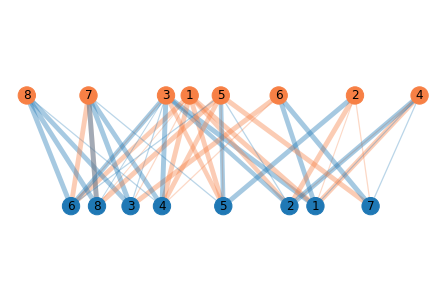

In [57]:
def layered(path):
    G = wrangle(path, normalise_flux=True, alpha_min=.3, alpha_max=.4)
    y_constraint = { i:G.nodes[i]['y']   for i in G.nodes }
    
    ### NOTE: the following lines can be used/uncommented to additionally fix the y axis ###
    # x_constraint = { i:G.nodes[i]['x']/2 for i in G.nodes if y_constraint[i]==0 }
    # x_constraint = { i:G.nodes[i]['x']/2 for i in G.nodes }
    x_constraint = None
    
    # weight_threshold can be used to cut weak links, but may break code if it disconnects the graph
    jonny_code.stress(G, 'figures/', y_constraint=y_constraint, x_constraint=x_constraint, weight_threshold=0)

# saves layered drawing to 'figures/NetworkR=3rpt=37_stress.png'
layered('NetworkR=3rpt=37.csv')

## edge bundling

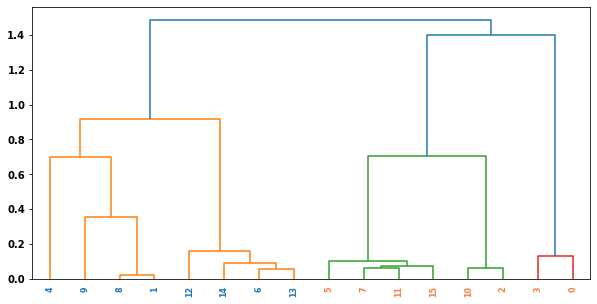

In [58]:
def bundle(path):
    G = wrangle(path, normalise_flux=False, alpha_min=.1, alpha_max=.7)
    hierarchy = jonny_code.cluster(nx.Graph(G), draw=True)
    jonny_code.bundle(G, hierarchy, 'figures/', merge_dist=.1, beta=.9, noderadius=.02)

# saves bundled drawing to 'figures/NetworkR=3rpt=37_bundled.png'
bundle('NetworkR=3rpt=37.csv')

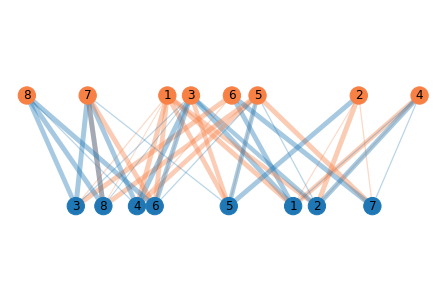

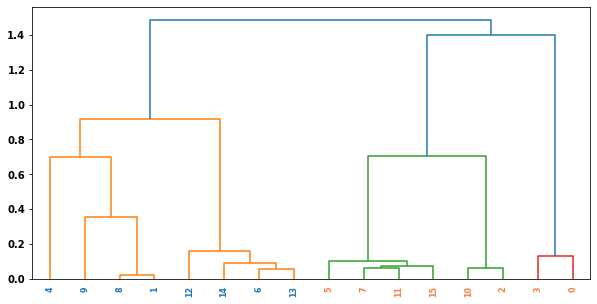

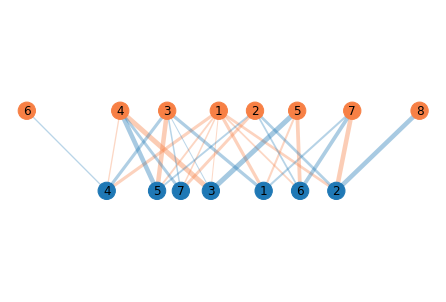

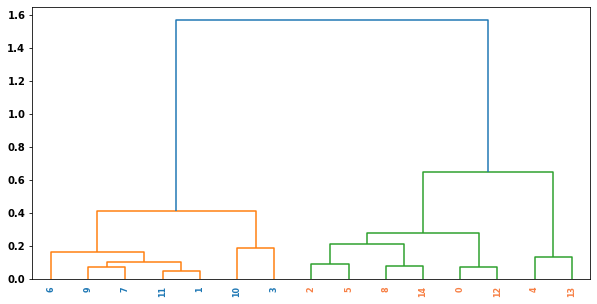

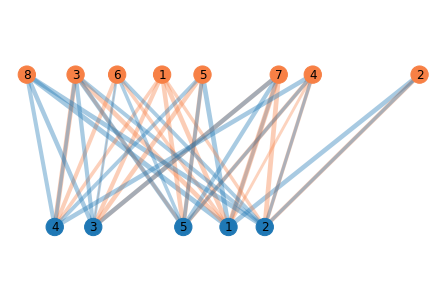

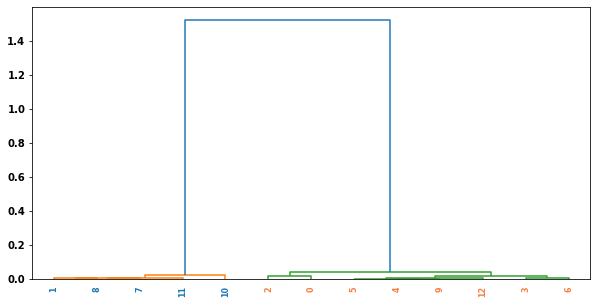

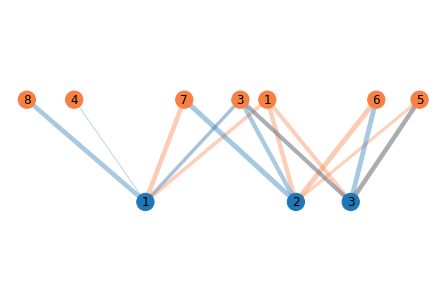

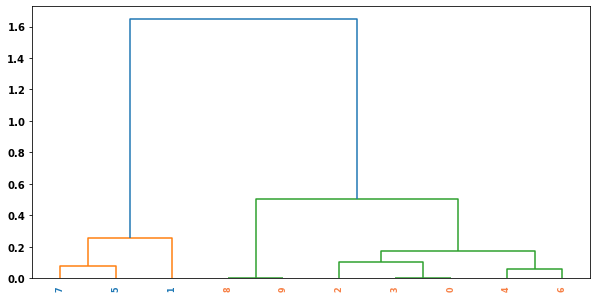

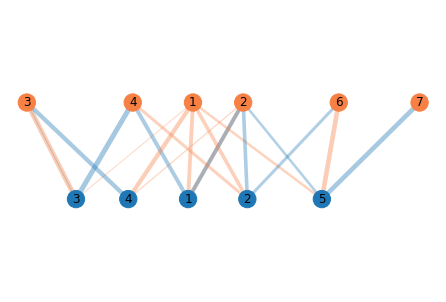

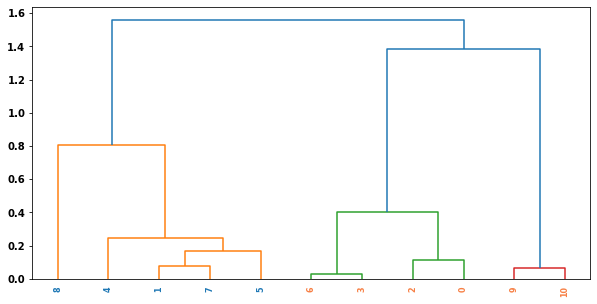

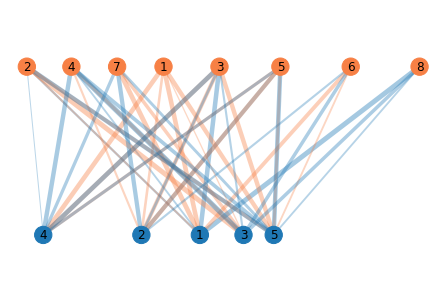

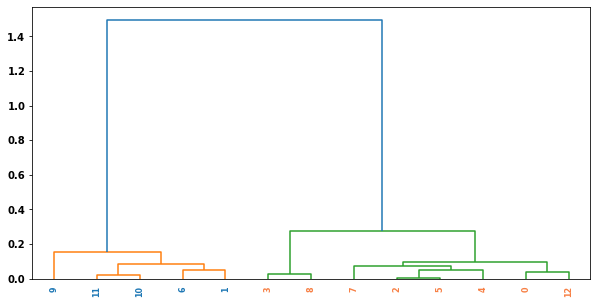

In [59]:
# does everything for all networks
for path in listdir():
    if re.match(r'.*\.csv$', path):
        layered(path)
        bundle(path)